In [100]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['font.family'] = 'futura'
import requests
from bs4 import BeautifulSoup

# Data preparation

In [82]:
# Load games
games = pd.read_csv('data/Premier-League_1995-2024.csv')
games = games[['Year', 'Date', 'Home', 'Away', 'G_home', 'G_away', 'Home_W', 'Draw', 'Away_W']]
games['Date'] = pd.to_datetime(games['Date'])
# Duplicate each game -- home and away team
teams = games['Home'].unique().tolist()
concat_dfs = []
for tm in teams :
    df_home = games[games['Home'] == tm]
    df_home = df_home.rename(columns = {'Home': 'Team', 'Away': 'Opponent', 'G_home': 'G_tm', 'G_away': 'G_opp', 'Home_W': 'Win', 'Away_W': 'Loss'})
    df_home['Home'] = 1
    concat_dfs.append(df_home)
    df_away = games[games['Away'] == tm]
    df_away = df_away.rename(columns = {'Home': 'Opponent', 'Away': 'Team', 'G_home': 'G_opp', 'G_away': 'G_tm', 'Home_W': 'Loss', 'Away_W': 'Win'})
    df_away['Home'] = 0
    concat_dfs.append(df_away)
games = pd.concat(concat_dfs).sort_values('Date').reset_index(drop = True)
games['PTS'] = 3 * games['Win'] + games['Draw']
# Rank team's games by date
games['Wk'] = games.groupby(['Year', 'Team'])['Date'].rank()
games.head()

,Year,Date,Team,Opponent,G_tm,G_opp,Win,Draw,Loss,Home,PTS,Wk
0,1996,1995-08-19,Southampton,Nott'ham Forest,3,4,0,0,1,1,0,1.0
1,1996,1995-08-19,QPR,Blackburn,0,1,0,0,1,0,0,1.0
2,1996,1995-08-19,Bolton,Wimbledon,2,3,0,0,1,0,0,1.0
3,1996,1995-08-19,Aston Villa,Manchester Utd,3,1,1,0,0,1,3,1.0
4,1996,1995-08-19,Manchester City,Tottenham,1,1,0,1,0,1,1,1.0


In [83]:
# Store time range of each season
season_dates = games.groupby('Year')['Date'].min().reset_index().merge(games.groupby('Year')['Date'].max().reset_index(), on = 'Year', suffixes = ['_min', '_max'])
season_dates.head()

,Year,Date_min,Date_max
0,1996,1995-08-19,1996-05-05
1,1997,1996-08-17,1997-05-11
2,1998,1997-08-09,1998-05-10
3,1999,1998-08-15,1999-05-16
4,2000,1999-08-07,2000-05-14


In [84]:
# Scrape table of Premier League managers
url = 'https://en.wikipedia.org/wiki/List_of_Premier_League_managers'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html')
table = soup.find_all('table')[1]
managers = pd.read_html(str(table))[0][['Name', 'Club', 'From', 'Until', 'Years in League']]
managers['From'] = pd.to_datetime(managers['From'].str.replace(r'\[[a-zA-Z]\]', '', regex = True))

# Map club name to match FBref names
club_map = {'Blackburn Rovers': 'Blackburn',
            'Bolton Wanderers': 'Bolton',
            'Brighton & Hove Albion': 'Brighton',
            'Charlton Athletic': 'Charlton Ath',
            'Huddersfield Town': 'Huddersfield',
            'Manchester United': 'Manchester Utd',
            'Newcastle United': 'Newcastle Utd',
            'Nottingham Forest': "Nott'ham Forest",
            'Queens Park Rangers': 'QPR',
            'Sheffield United': 'Sheffield Utd',
            'Tottenham Hotspur': 'Tottenham',
            'West Bromwich Albion': 'West Brom',
            'West Ham United': 'West Ham',
            'Wolverhampton Wanderers': 'Wolves'}
managers['Club'] = managers['Club'].apply(lambda x: club_map.get(x) if x in club_map.keys() else x)

# Get the date of manager's first game
def get_debut_date(row) :
    games_ = games[games['Team'] == row['Club']]
    following_dates = [date for date in games_['Date'].tolist() if date > row['From']]
    if len(following_dates) > 1 :
        return min(following_dates)
    else :
        return np.nan # NaN if manager started later than 2023-24
    # Note: managers how debuted before 2000 will be easily discarded as their first game would be in week 1

# Get first game date of all managers
managers['debut_date'] = managers.apply(get_debut_date, axis = 1)
managers = managers.copy()[managers['debut_date'].notna()]

managers = managers[['Name', 'Club', 'debut_date']]
managers['caretaker'] = managers['Name'].apply(lambda x: '‡' in x)
managers['Name'] = managers['Name'].str.replace(' ‡', '').str.replace(' †', '').str.replace(' §', '')
managers.head()

,Name,Club,debut_date,caretaker
0,George Graham,Arsenal,1995-08-20,False
1,Stewart Houston,Arsenal,1995-08-20,True
2,Bruce Rioch,Arsenal,1995-08-20,False
3,Stewart Houston,Arsenal,1996-08-17,True
4,Pat Rice,Arsenal,1996-09-16,True


In [85]:
# Number of games before/after new manager
bounceTime = 5

In [86]:
# Inner merge of games and manager debuts
debuts = games.merge(managers.rename(columns = {'debut_date': 'Date', 'Club': 'Team'}), on = ['Date', 'Team'], how = 'inner')

# Only keep debuts with enough games before and after
debuts = debuts[(debuts['Wk'] > bounceTime) & (debuts['Wk'] <= 38 - bounceTime + 1)]

# Additionally, only keep debuts if new manager played at least 'bounceTime' games
dfs = []
for _, df in debuts.groupby(['Year', 'Team']) :
    if len(df) > 1:
        #                  Checks if there is a new debut bouceTime away from a given debut
        df['valid'] = [1 - max([(x - w) < bounceTime and (x - w) > 0 for x in df['Wk']]) for w in df['Wk']]
        dfs.append(df[df['valid'] == 1].drop(columns = ['valid']))
    else :
        dfs.append(df)

debuts = pd.concat(dfs).sort_values(['Year', 'Wk']).reset_index(drop = True)
# If there are duplicates by team and debut date, it means a caretaker took charge but did not manage one game
debuts['duplicated'] = debuts.duplicated(subset = ['Date', 'Team'], keep = False)
debuts = debuts[(~debuts['duplicated']) | (~debuts['caretaker'])]
debuts = debuts.drop(columns = ['duplicated', 'caretaker']).reset_index(drop = True)
debuts.tail()

,Year,Date,Team,Opponent,G_tm,G_opp,Win,Draw,Loss,Home,PTS,Wk,Name
161,2023,2023-04-15,Leicester City,Manchester City,1,3,0,0,1,0,0,31.0,Dean Smith
162,2023,2023-04-27,Tottenham,Manchester Utd,2,2,0,1,0,1,1,33.0,Ryan Mason
163,2024,2023-12-06,Sheffield Utd,Liverpool,0,2,0,0,1,1,0,15.0,Chris Wilder
164,2024,2023-12-23,Nott'ham Forest,Bournemouth,2,3,0,0,1,1,0,18.0,Nuno Espírito Santo
165,2024,2024-02-24,Crystal Palace,Burnley,3,0,1,0,0,1,3,26.0,Oliver Glasner


# Analysis

In [87]:
# Compute points per game and goal difference per game before and after manager debut 
ppg_before, ppg_after = [], []
gd_before, gd_after = [], []
for yr, tm, w in zip(debuts['Year'], debuts['Team'], debuts['Wk']) :
    games_sub = games.copy()[(games['Year'] == yr) & (games['Team'] == tm)]
    games_sub = games_sub[(games_sub['Wk'] >= w - bounceTime) & (games_sub['Wk'] < w + bounceTime)].sort_values('Date')

    ppg_before.append(games_sub.head(bounceTime)['PTS'].mean())
    ppg_after.append(games_sub.tail(bounceTime)['PTS'].mean())
    gd_before.append(games_sub.head(bounceTime)['G_tm'].mean() - games_sub.head(bounceTime)['G_opp'].mean())
    gd_after.append(games_sub.tail(bounceTime)['G_tm'].mean() - games_sub.tail(bounceTime)['G_opp'].mean())

debuts['ppg_before'] = ppg_before
debuts['ppg_after'] = ppg_after
debuts['gd_before'] = gd_before
debuts['gd_after'] = gd_after

# Compute the difference between before and after manager debut 
debuts['ppg_imp'] = debuts['ppg_after'] - debuts['ppg_before']
debuts['gd_imp'] = debuts['gd_after'] - debuts['gd_before']

debuts.sort_values('ppg_imp', ascending = False)

,Year,Date,Team,Opponent,G_tm,G_opp,Win,Draw,Loss,Home,PTS,Wk,Name,ppg_before,ppg_after,gd_before,gd_after,ppg_imp,gd_imp
112,2017,2017-02-27,Leicester City,Liverpool,3,1,1,0,0,1,3,26.0,Craig Shakespeare,0.0,3.0,-2.4,1.8,3.0,4.2
46,2006,2006-02-04,Newcastle Utd,Portsmouth,2,0,1,0,0,1,3,24.0,Glenn Roeder,0.2,2.6,-1.4,1.4,2.4,2.8
123,2018,2018-04-07,West Brom,Swansea City,1,1,0,1,0,1,1,33.0,Darren Moore,0.0,2.2,-1.4,0.6,2.2,2.0
159,2023,2023-04-01,Crystal Palace,Leicester City,2,1,1,0,0,1,3,29.0,Roy Hodgson,0.2,2.0,-1.2,1.0,1.8,2.2
64,2009,2008-12-20,Blackburn,Stoke City,3,0,1,0,0,1,3,18.0,Sam Allardyce,0.0,1.8,-1.6,1.2,1.8,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,2023,2023-04-08,Chelsea,Wolves,0,1,0,0,1,0,0,30.0,Frank Lampard,1.6,0.6,0.2,-0.8,-1.0,-1.0
61,2009,2008-10-26,Portsmouth,Fulham,1,1,0,1,0,1,1,9.0,Tony Adams,2.0,1.0,-0.4,-0.2,-1.0,0.2
27,2002,2002-02-09,Aston Villa,Chelsea,1,1,0,1,0,1,1,26.0,Graham Taylor,1.8,0.8,0.4,-0.8,-1.0,-1.2
150,2023,2022-10-01,Brighton,Liverpool,3,3,0,1,0,0,1,7.0,Roberto De Zerbi,2.0,0.4,1.0,-1.0,-1.6,-2.0


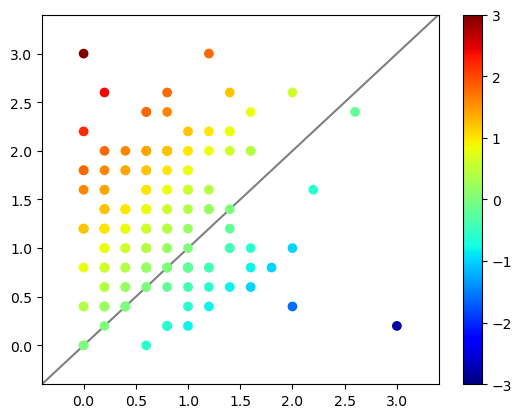

In [88]:
plt.plot([-1, 4], [-1, 4], c = 'k', alpha = 0.5, zorder = 1)
plt.scatter(debuts['ppg_before'], debuts['ppg_after'], c = debuts['ppg_imp'], cmap = 'jet', vmin = -3, vmax = 3)
plt.xlim([-0.4, 3.4])
plt.ylim([-0.4, 3.4])
plt.colorbar()
plt.show()

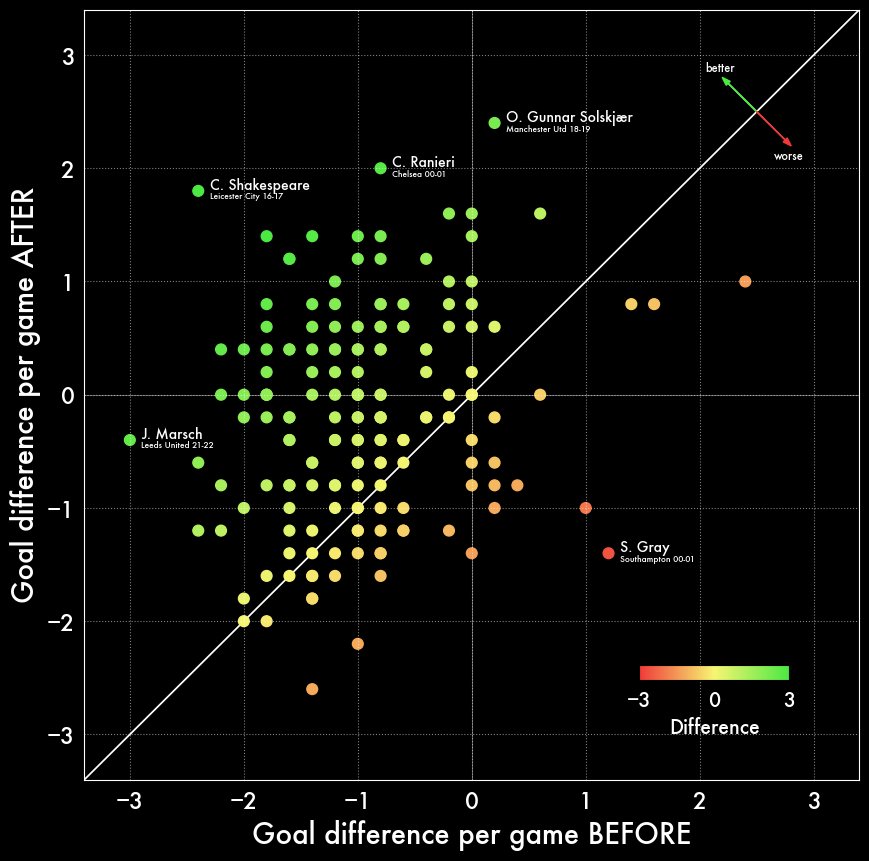

In [272]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor = 'k')
ax.set_facecolor('k')

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#f03a3a', '#f7f572', '#4ce843'])

plt.plot([-5, 5], [0, 0], c = 'w', zorder = -2, linewidth = 0.5, alpha = 0.5)
plt.plot([0, 0], [-5, 5], c = 'w', zorder = -2, linewidth = 0.5, alpha = 0.5)
plt.plot([-5, 5], [-5, 5], c = 'w', linewidth = 1.25, zorder = -1)
sc = plt.scatter(debuts['gd_before'], debuts['gd_after'], c = debuts['gd_imp'], s = 60, cmap = cmap, vmin = -3, vmax = 3)

for name, tm, yr, bef, aft in zip(debuts['Name'], debuts['Team'], debuts['Year'], debuts['gd_before'], debuts['gd_after']) :
    if max([x in name for x in ['Shakespeare', 'Ranieri', 'Solskjær', 'Marsch', 'Stuart Gray']]) and np.abs(bef - aft) >= 2 :
        plt.text(bef + 0.1, aft + 0.05, name.split(' ')[0][0] + '. ' + ' '.join(name.split(' ')[1:]), zorder = 1001, va = 'center', ha = 'left', size = 10, color = 'w')
        plt.text(bef + 0.1, aft - 0.05, tm + ' ' + str(yr-1)[-2:] + '-' + str(yr)[-2:], zorder = 1001, va = 'center', ha = 'left', size = 6, color = 'w')

# plt.text(-2.5, 2.8, 'Very good', zorder = 1001, va = 'center', ha = 'center', size = 12, color = '#4ce843')
# plt.text(2.5, -2.8, 'Very bad', zorder = 1001, va = 'center', ha = 'center', size = 12, color = '#f03a3a')

plt.xlim([-3.4, 3.4])
plt.ylim([-3.4, 3.4])
plt.xlabel('Goal difference per game BEFORE', color = 'w', size = 20); plt.ylabel('Goal difference per game AFTER', color = 'w', size = 20)
plt.xticks(color = 'w', size = 16); plt.yticks(color = 'w', size = 16)
plt.grid(color = 'w', alpha = 0.5, linestyle = ':')
for spine in ax.spines.values():
    spine.set_edgecolor('w')
ax.arrow(2.5, 2.5, -.25, .25, color = '#4ce843', head_width = 0.05); ax.text(2.05, 2.85, 'better', size = 8, color = 'w')
ax.arrow(2.5, 2.5, .25, -.25, color = '#f03a3a', head_width = 0.05); ax.text(2.65, 2.08, 'worse', size = 8, color = 'w')

# Colorbar
cbar_ax = fig.add_axes([0.68, 0.21, 0.15, 0.015])  # [left, bottom, width, height]
cbar = plt.colorbar(sc, cax = cbar_ax, orientation = 'horizontal')
cbar.set_label('Color Intensity')
cbar.set_ticks([-3, 0, 3])
cbar.ax.xaxis.set_tick_params(labelcolor = 'white', labelsize = 14)
cbar.ax.set_xlabel('Difference', color = 'white', size = 14)

plt.savefig('gd_before_after.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [273]:
debuts['ppg_imp']

0      1.0
1     -0.8
2     -0.6
3      1.0
4     -0.2
      ... 
161    0.8
162   -0.2
163    0.0
164    1.0
165    0.2
Name: ppg_imp, Length: 166, dtype: float64

(array([ 1.,  0.,  1.,  7., 22., 46., 64., 15.,  8.,  2.]),
 array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ]),
 <BarContainer object of 10 artists>)

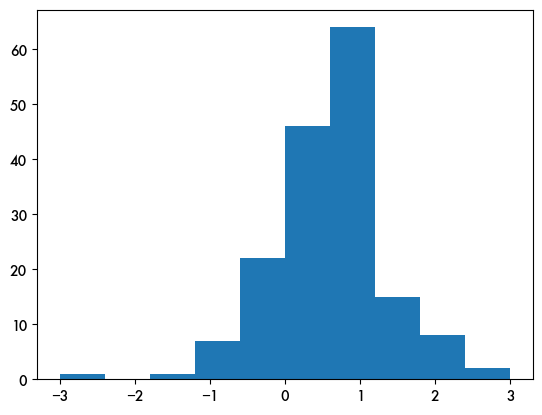

In [149]:
plt.hist(debuts['ppg_imp'], bins = 10, range = [-3, 3])

In [159]:
debuts['ppg_imp'].mean(), debuts['gd_imp'].mean()

(0.5337349397590361, 0.7566265060240964)

In [276]:
bounce_rate = (debuts['ppg_imp'] < 0).mean()
round(100 * bounce_rate, 1)

18.7

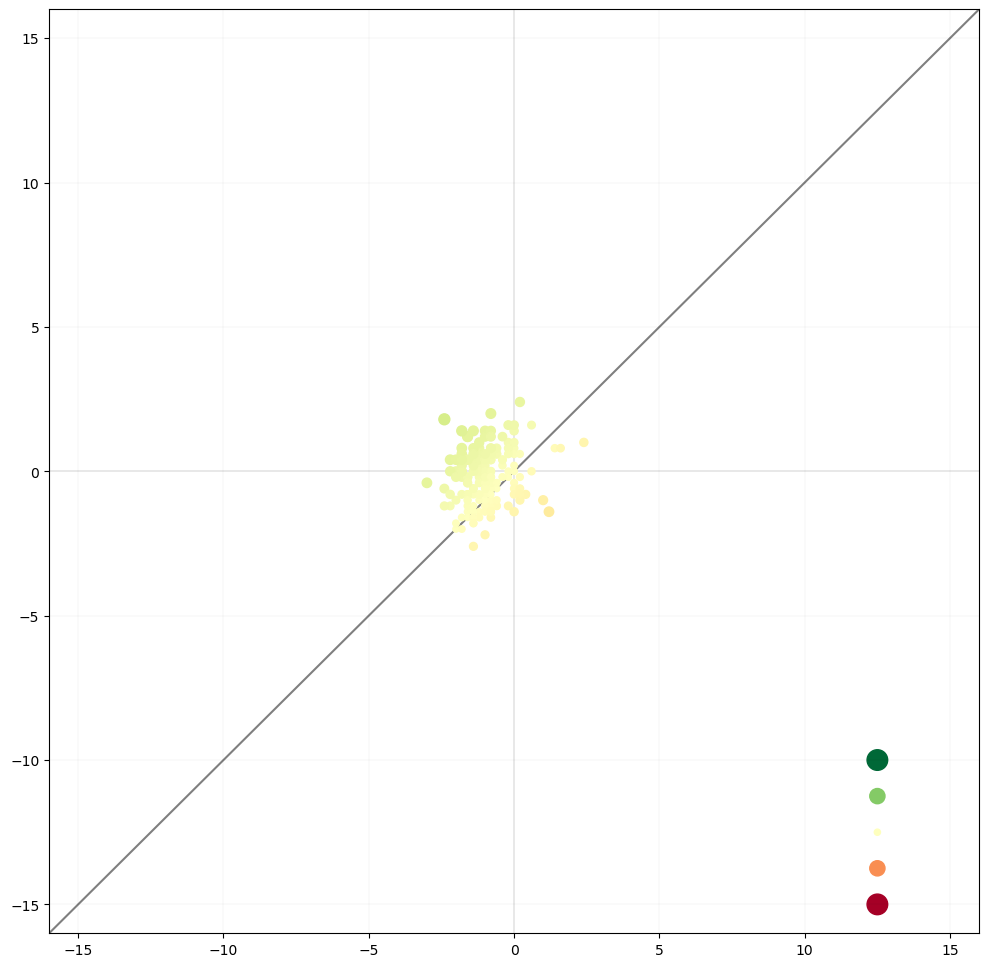

In [92]:
plt.figure(figsize = (12, 12))

plt.plot([-20, 20], [0, 0], c = 'k', linewidth = 0.1)
plt.plot([0, 0], [-20, 20], c = 'k', linewidth = 0.1)
plt.plot([-20, 20], [-20, 20], c = 'k', alpha = 0.5)
plt.scatter(debuts['gd_before'], debuts['gd_after'], c = debuts['gd_imp'], s = 10 * (debuts['gd_imp'].abs() + 2), cmap = 'RdYlGn', zorder = 1000, vmin = -20, vmax = 20)
for name, tm, yr, bef, aft in zip(debuts['Name'], debuts['Team'], debuts['Year'], debuts['gd_before'], debuts['gd_after']) :
    if np.abs(aft - bef) >= 10 :
        txt = f'{name}\n{tm}\n{yr-1}-{str(yr)[-2:]}'
        txt = name
        plt.text(bef - .5, aft, txt, zorder = 1001, va = 'center', ha = 'right', size = 6)
plt.xlim([-16, 16])
plt.ylim([-16, 16])
plt.scatter(5 * [12.5], np.linspace(-10, -15, 5), c = np.linspace(20, -20, 5), vmin = -20, vmax = 20, s = 10 * (np.abs(np.linspace(20, -20, 5)) + 2), cmap = 'RdYlGn')
plt.grid(c = 'k', linewidth = 0.1, alpha = 0.25)
plt.show()

In [636]:
round(debuts['gd_imp'].mean(), 2)

3.92

In [157]:
round(debuts['gd_imp'].mean(), 2)

0.76

In [152]:
debuts_sorted = debuts.sort_values('gd_imp', ascending = False).reset_index(drop = True)

In [155]:
debuts_sorted.head(50)

,Year,Date,Team,Opponent,G_tm,G_opp,Win,Draw,Loss,Home,PTS,Wk,Name,ppg_before,ppg_after,gd_before,gd_after,ppg_imp,gd_imp
0,2017,2017-02-27,Leicester City,Liverpool,3,1,1,0,0,1,3,26.0,Craig Shakespeare,0.0,3.0,-2.4,1.8,3.0,4.2
1,2014,2013-12-22,Tottenham,Southampton,3,2,1,0,0,0,3,17.0,Tim Sherwood,1.4,2.6,-1.8,1.4,1.2,3.2
2,2006,2006-02-04,Newcastle Utd,Portsmouth,2,0,1,0,0,1,3,24.0,Glenn Roeder,0.2,2.6,-1.4,1.4,2.4,2.8
3,2009,2008-12-20,Blackburn,Stoke City,3,0,1,0,0,1,3,18.0,Sam Allardyce,0.0,1.8,-1.6,1.2,1.8,2.8
4,1998,1998-02-28,Aston Villa,Liverpool,2,1,1,0,0,1,3,28.0,John Gregory,0.6,2.4,-1.6,1.2,1.8,2.8
5,2001,2000-09-23,Chelsea,Manchester Utd,3,3,0,1,0,0,1,7.0,Claudio Ranieri,0.6,2.0,-0.8,2.0,1.4,2.8
6,2015,2015-02-21,Aston Villa,Stoke City,1,2,0,0,1,1,0,26.0,Tim Sherwood,0.0,1.2,-2.2,0.4,1.2,2.6
7,2022,2022-03-05,Leeds United,Leicester City,0,1,0,0,1,0,0,27.0,Jesse Marsch,0.2,1.4,-3.0,-0.4,1.2,2.6
8,2000,1999-09-11,Newcastle Utd,Chelsea,0,1,0,0,1,0,0,7.0,Bobby Robson,0.2,1.2,-1.8,0.8,1.0,2.6
9,2009,2008-12-06,Sunderland,Manchester Utd,0,1,0,0,1,0,0,16.0,Ricky Sbragia,0.6,1.4,-1.8,0.6,0.8,2.4


In [158]:
debuts

,Year,Date,Team,Opponent,G_tm,G_opp,Win,Draw,Loss,Home,PTS,Wk,Name,ppg_before,ppg_after,gd_before,gd_after,ppg_imp,gd_imp
0,1996,1996-01-13,Bolton,Wimbledon,1,0,1,0,0,1,3,23.0,Colin Todd,0.2,1.2,-1.2,-0.2,1.0,1.0
1,1997,1996-09-14,Leeds United,Coventry City,1,2,0,0,1,0,0,6.0,George Graham,1.4,0.6,-0.8,-0.6,-0.8,0.2
2,1997,1996-10-12,Arsenal,Blackburn,2,0,1,0,0,0,3,9.0,Arsène Wenger,2.2,1.6,1.4,0.8,-0.6,-0.6
3,1997,1996-10-26,Blackburn,West Ham,1,2,0,0,1,0,0,11.0,Tony Parkes,0.6,1.6,-0.6,0.6,1.0,1.2
4,1997,1996-11-16,Coventry City,Wimbledon,2,2,0,1,0,0,1,13.0,Gordon Strachan,1.0,0.8,0.0,-0.4,-0.2,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2023,2023-04-15,Leicester City,Manchester City,1,3,0,0,1,0,0,31.0,Dean Smith,0.2,1.0,-1.0,-0.6,0.8,0.4
162,2023,2023-04-27,Tottenham,Manchester Utd,2,2,0,1,0,1,1,33.0,Ryan Mason,1.0,0.8,-1.0,-0.6,-0.2,0.4
163,2024,2023-12-06,Sheffield Utd,Liverpool,0,2,0,0,1,1,0,15.0,Chris Wilder,0.8,0.8,-2.2,-0.8,0.0,1.4
164,2024,2023-12-23,Nott'ham Forest,Bournemouth,2,3,0,0,1,1,0,18.0,Nuno Espírito Santo,0.2,1.2,-1.8,0.0,1.0,1.8


In [277]:
debuts.head()

,Year,Date,Team,Opponent,G_tm,G_opp,Win,Draw,Loss,Home,PTS,Wk,Name,ppg_before,ppg_after,gd_before,gd_after,ppg_imp,gd_imp
0,1996,1996-01-13,Bolton,Wimbledon,1,0,1,0,0,1,3,23.0,Colin Todd,0.2,1.2,-1.2,-0.2,1.0,1.0
1,1997,1996-09-14,Leeds United,Coventry City,1,2,0,0,1,0,0,6.0,George Graham,1.4,0.6,-0.8,-0.6,-0.8,0.2
2,1997,1996-10-12,Arsenal,Blackburn,2,0,1,0,0,0,3,9.0,Arsène Wenger,2.2,1.6,1.4,0.8,-0.6,-0.6
3,1997,1996-10-26,Blackburn,West Ham,1,2,0,0,1,0,0,11.0,Tony Parkes,0.6,1.6,-0.6,0.6,1.0,1.2
4,1997,1996-11-16,Coventry City,Wimbledon,2,2,0,1,0,0,1,13.0,Gordon Strachan,1.0,0.8,0.0,-0.4,-0.2,-0.4


In [340]:
rolling_ppg_imp = np.zeros((38,))
rolling_ppg_imp_count = np.zeros((38,))

In [349]:
rolling_ppg_imp = np.zeros((38,))
rolling_ppg_imp_count = np.zeros((38,))
rolling_gd_imp = np.zeros((38,))
rolling_gd_imp_count = np.zeros((38,))

# Compute points per game and goal difference per game before and after manager debut 
ppg_before, ppg_after = [], []
gd_before, gd_after = [], []
for yr, tm, w in zip(debuts['Year'], debuts['Team'], debuts['Wk']) :
    games_before = games.copy()[(games['Year'] == yr) & (games['Team'] == tm)]
    games_before = games_before[(games_before['Wk'] < w) & (games_before['Wk'] >= w - 5)].sort_values('Date')
    ppg_baseline = games_before['PTS'].mean()
    gd_baseline = (games_before['G_tm'] - games_before['G_opp']).mean()

    games_after = games.copy()[(games['Year'] == yr) & (games['Team'] == tm)]
    games_after = games_after[games_after['Wk'] >= w].sort_values('Date')

    ppg_rolling = games_after['PTS'].rolling(5, min_periods = 1).mean() - games_after.head(5)['PTS'].mean()
    rolling_ppg_imp[:len(games_after)] += ppg_rolling
    rolling_ppg_imp_count[:len(games_after)] += np.ones((len(games_after,)))

    gd_rolling = (games_after['G_tm'] - games_after['G_opp']).rolling(5, min_periods = 1).mean() - (games_after.head(5)['G_tm'] - games_after.head(5)['G_opp']).mean()
    rolling_gd_imp[:len(games_after)] += gd_rolling
    rolling_gd_imp_count[:len(games_after)] += np.ones((len(games_after,)))

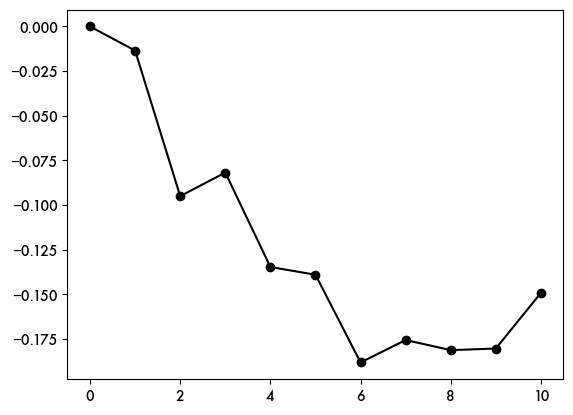

In [351]:
plt.plot(rolling_gd_imp[4:15] / rolling_gd_imp_count[4:15], 'k-o')

<Axes: >

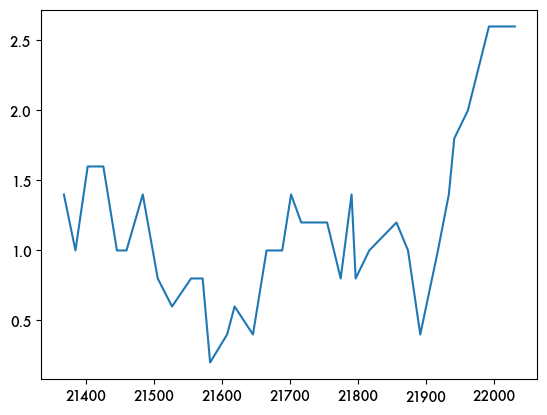

In [337]:
pd.concat([games_before, games_after])['PTS'].rolling(5).mean().plot()